In [1]:
import bagpipes as pipes
import numpy as np
from astropy.table import Table
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
from scipy.interpolate import interp1d
from scipy.integrate import simps

from astropy.cosmology import WMAP9 as cosmo
import itertools as it
# Setting to read filter files from the team drive

# Handling constants/units like this cause I'm old
c_A = 2.9979e18 # speed of light in Angstrom/s
np.seterr(divide='ignore')
directory = './'

In [2]:
def my_plot_style():
    params = {'legend.fontsize': 15,
    'axes.labelsize': 15,
    'axes.titlesize':15,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'xtick.major.size':5,
    'xtick.minor.size':2.5,
    'ytick.major.size':5,
    'ytick.minor.size':2.5,
    'figure.facecolor':'w',
    #'lines.linewidth' : 1.5,
    'xtick.major.width':2.5,
    'ytick.major.width':2.5,
    'xtick.minor.width':2.5,
    'ytick.minor.width':2.5,
    'axes.linewidth':1.5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'ytick.labelleft':True,
    'text.usetex' : False,
    'font.family': 'sans-serif'}
    plt.rcParams.update(params)
my_plot_style()

In [3]:
def getfilter(filtername):
    filter = Table.read('filters/{}.dat'.format(filtername), format='ascii')
    filter.rename_column('col1', 'wave')
    filter.rename_column('col2', 'transmission')
    filter['nu'] = c_A/filter['wave']
    return filter

def bagpipes_burst(age, massformed, metallicity, Av, redshift,
                   lambda_min=1000, lambda_max=10000, delta_lambda=10):

  # The first stellar population we will explore is just a simple one.
  # This means that the star formation history is a delta function.
    burst = {}                           # Delta function burst
    burst["age"] = age
    burst["massformed"] = massformed   # Log_10 total stellar mass formed: M_Solar
    burst["metallicity"] = metallicity  # Metallicity: Z_sol = 0.02

    dust = {}                         # Dust component
    dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
    dust["Av"] = Av                  # magnitudes


    model_components = {}                   # The model components dictionary
    model_components["redshift"] = redshift      # Observed redshift  
    model_components["burst"] = burst   
    model_components["dust"] = dust


    filt_list = ['filters/DECam_u.dat', directory + 'filters/DECam_z.dat']

    spec_waves = np.arange(lambda_min, lambda_max, delta_lambda)

    model = pipes.model_galaxy(model_components, filt_list=filt_list, spec_wavs=spec_waves)

    spec = Table()
    spec['wave'] = spec_waves
    spec['flux'] = model.spectrum[:, 1]

    return spec, model

def broad_spec(age, massformed, metallicity, Av, redshift,
                   lambda_min=1000, lambda_max=25000, delta_lambda=10):
    spec1, model = bagpipes_burst(age, massformed, metallicity, Av, redshift,
                   lambda_min=lambda_min, lambda_max=10000, delta_lambda=delta_lambda)
    spec2, model = bagpipes_burst(age, massformed, metallicity, Av, redshift,
                   lambda_min=10000, lambda_max=lambda_max, delta_lambda=delta_lambda)
    return list(spec1['wave'])+list(spec2['wave']), list(spec1['flux'])+list(spec2['wave'])

## A function that gets an absolute magnitude for a bagpipes model at z=0.
def absmag(lam, flux, filter_name):
    area = 4.0*np.pi*(3.086e19)**2 # area of a sphere of radius 10 pc in cm^2
    filter = getfilter(filter_name)
    nu  = c_A/lam
    fnu = lam/nu*flux
    filter_interp = interp1d(filter['nu'], filter['transmission'],
                             bounds_error=False, fill_value=0.0)
    numerator = simps(fnu*filter_interp(nu)/nu/area, nu)
    denominator = simps(3631.0e-23*filter_interp(nu)/nu, nu)
    return -2.5*np.log10(numerator/denominator)

In [4]:
def sps(age,met,ext,mass=11,filters=['Suprimecam_g','Suprimecam_r','VISTA_Ks'],magsun=[5.05,4.61,5.12]):
    spec1, model = bagpipes_burst(age, mass, met, ext, 0.0,lambda_max=10000)
    spec2, model = bagpipes_burst(age, mass, met, ext, 0.0,lambda_min=10000,lambda_max=25000)
    lam, flux = np.array(list(spec1['wave'])+list(spec2['wave'])), np.array(list(spec1['flux'])+list(spec2['flux']))
    
    # Calculate u-g color
    u = absmag(lam,flux,'Megacam_u')
    g = absmag(lam,flux,'Suprimecam_g')
    r = absmag(lam,flux,'Suprimecam_r')
    
    # Calculate mass 2 bolometric light ratio
    light = simps(flux,lam) # erg/s
    sun_light = 3.846e33    # erg/s
    mass2bolo = 10**mass/(light/sun_light) # Msun/Lsun
    
    # Calculate mass 2 light at g, r, K band
    m2l_band = []
    for i,filt in enumerate(filters):
        mag = absmag(lam,flux,filt)
        m2l_band.append(10**mass/10**(-0.4*(mag-magsun[i])))
    return u-g, g-r, mass2bolo, m2l_band
def shift_z(lam,flux,z):
    lam = lam*(1+z)
    flux = flux/(4*np.pi*(cosmo.luminosity_distance(z).value*3.08568e24)**2.0)/(1+z)
    return lam, flux
def app_mag(lam,flux,z,filter):
    filter = getfilter(filter)
    trans = interp1d(filter['wave'],filter['transmission'],bounds_error=False, fill_value=0.0)

    lam, flux = shift_z(lam, flux, z)
    frac  = trans(lam)
    nom = simps(flux*frac,lam)       #np.sum(flux*frac*dlam)
    dom = simps(3631.0e-23/lam**2.0*c_A*frac,lam) #np.sum(3631e-23*dlam*frac)
    return -2.5*np.log10(nom/dom)

In [5]:
class spec:
    def __init__(self,met,ext):
        self.met  = met
        self.ext  = ext
        self.data = Table()

In [6]:
mets = 10**np.array([-2,-1,0.,0.2])
plt_mets = ['-','--','-.',':']
exts = [0,1,2]
plt_exts = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
filtername = ['Suprimecam_g','Suprimecam_r','VISTA_Ks']
ages = [0.1,0.5,1,3,6,9]
size = 5

data = []
for i,met in enumerate(mets):
    sub_data = []
    for j,ext in enumerate(exts):
        u_gs, g_rs, m2bs, m2l_bands = [], [], [], []
        for age in ages:
            u_g, g_r, m2b, m2l = sps(age,met,ext)
            u_gs.append(u_g)
            g_rs.append(g_r)
            m2bs.append(m2b)
            m2l_bands.append(m2l)
        sample = spec(met,ext)
        sample.data['u_g'] = u_gs
        sample.data['g_r'] = g_rs
        sample.data['m2b'] = m2bs
        sample.data['m2l'] = np.array(m2l_bands)
        sample.data['age'] = ages
        sub_data.append(sample)
    data.append(sub_data)
data = np.array(data)

### A. Plot u-g color versus age (Figure 1-a)

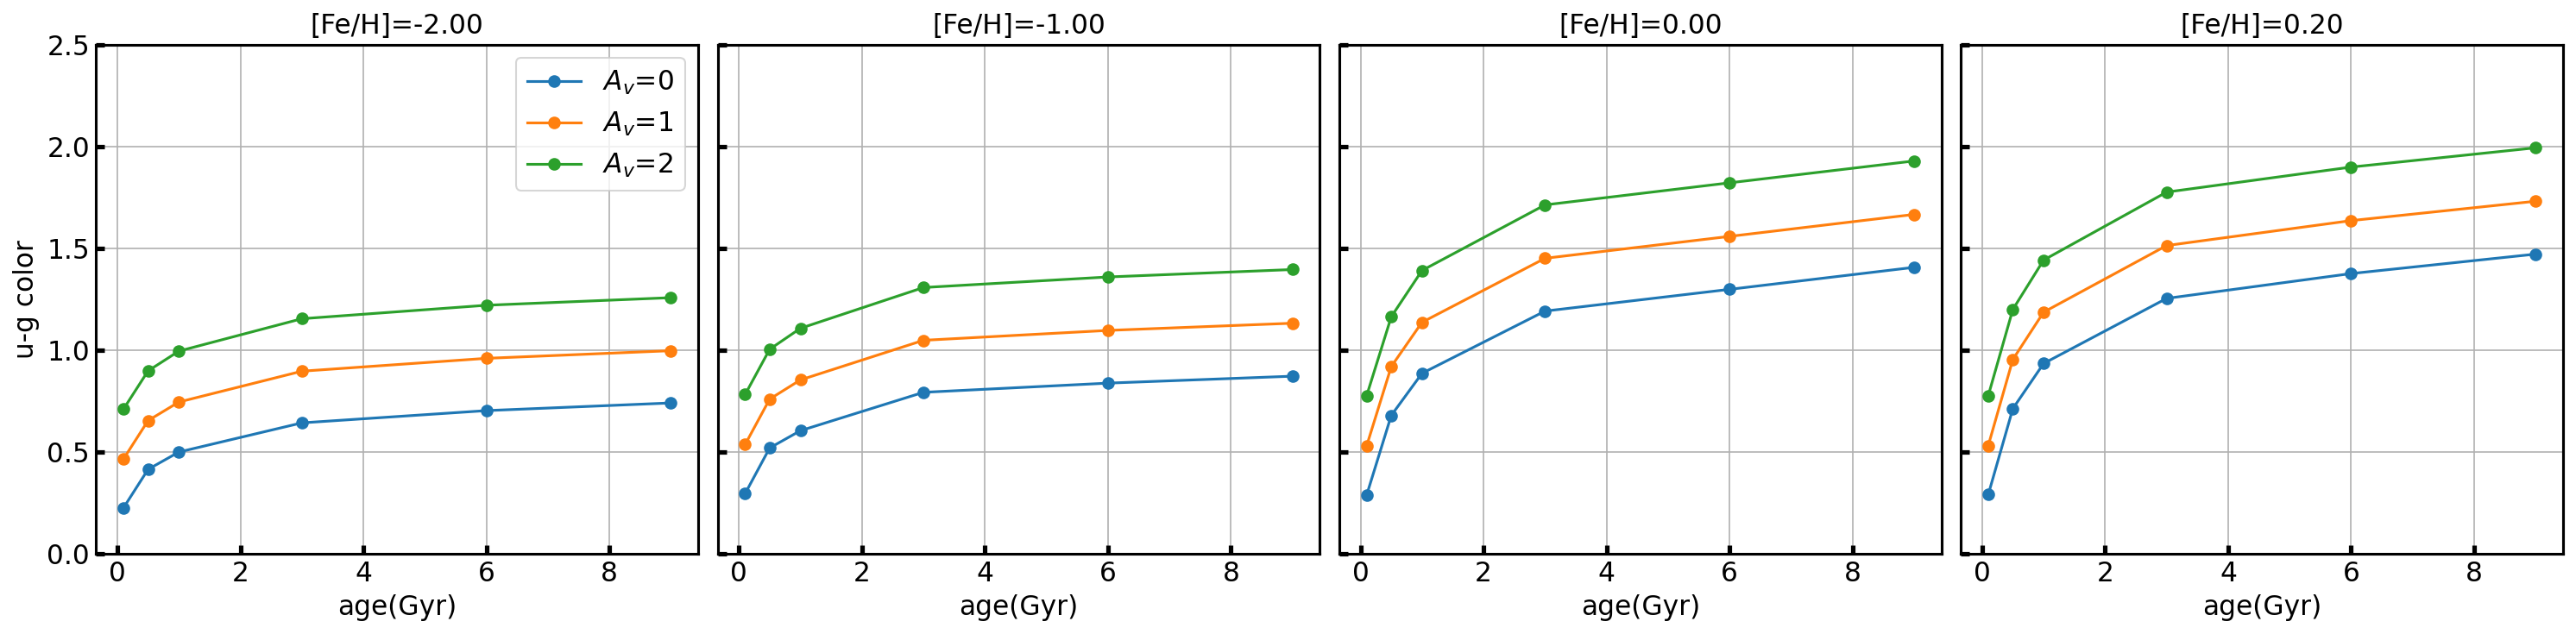

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,5))
for i in range(4): # loop: metallicity
    for j in range(3): # loop: extinction
        ax = axes[i]
        ydata = data[i,j].data['u_g']
        xdata = data[i,j].data['age']
        ax.plot(xdata,ydata,'-o',label='$A_v$='+str(exts[j]))
    if( i==0 ): 
        ax.legend()
        ax.set_ylabel('u-g color')
    if( i!=0 ): ax.set_yticklabels([])
    ax.set_xlabel('age(Gyr)')
    ax.set_ylim([0,2.5])
    ax.set_title(f'[Fe/H]={np.log10(data[i,j].met):.2f}')
    ax.grid()
plt.tight_layout()

### B. Plot mass-to-bolometric light ratio vs age (Figure 1-b)

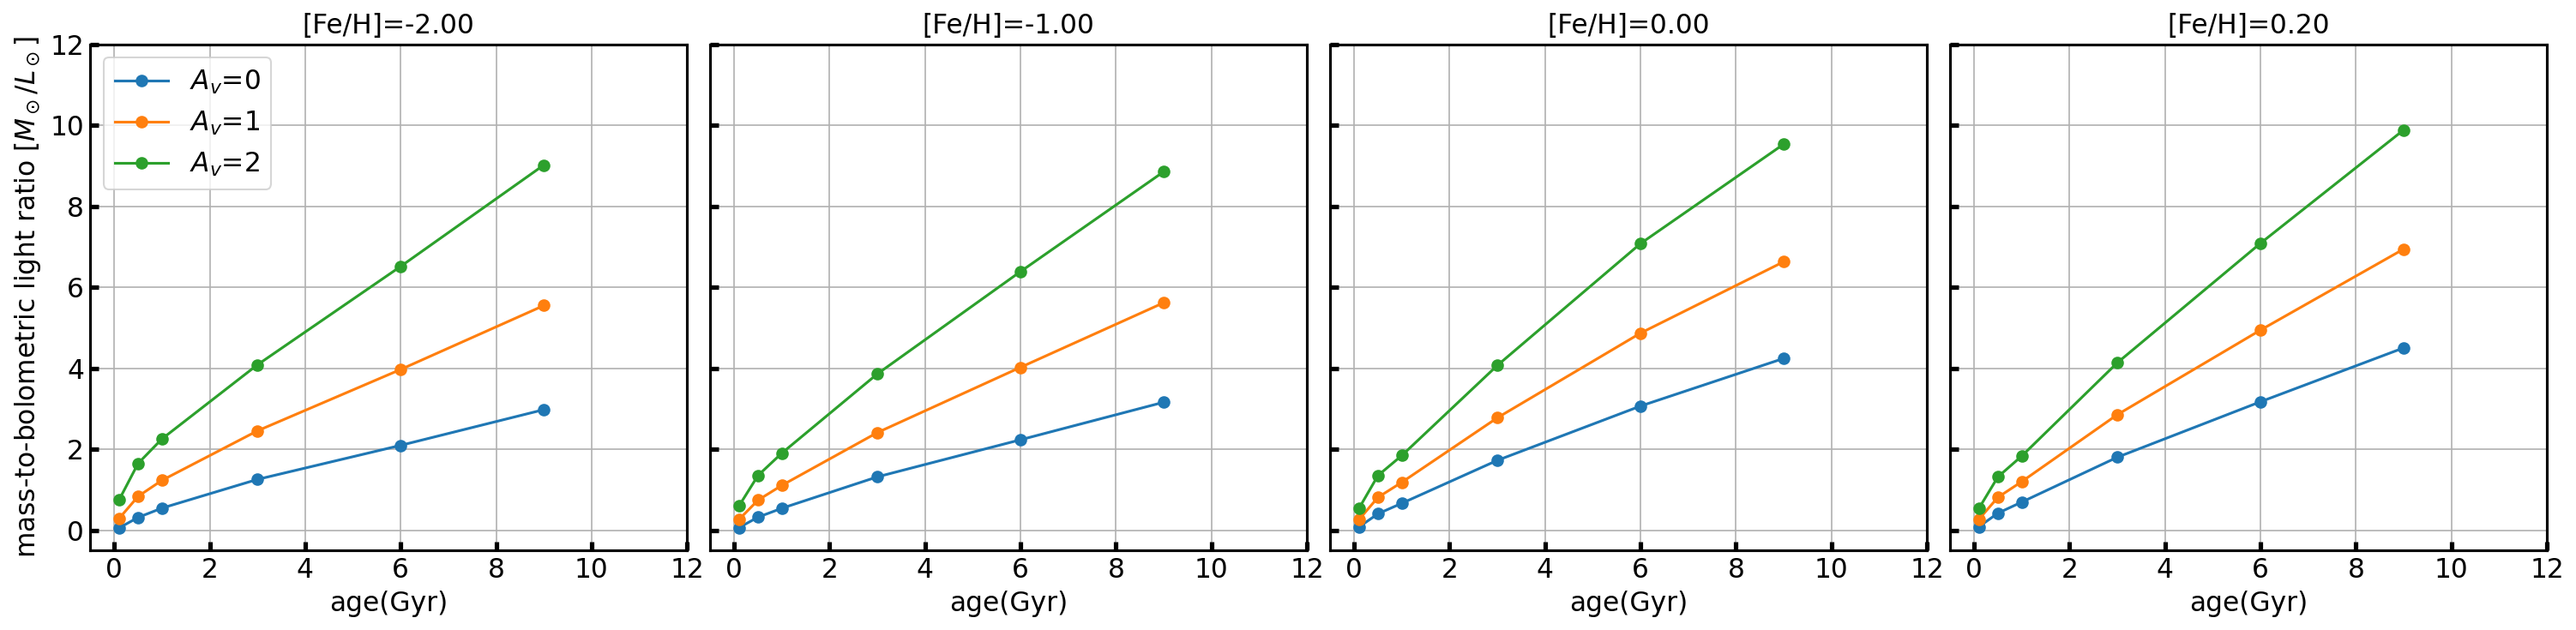

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,5))
for i in range(4): # loop: metallicity
    for j in range(3): # loop: extinction
        ax = axes[i]
        ydata = data[i,j].data['m2b']
        xdata = data[i,j].data['age']
        ax.plot(xdata,ydata,'-o',label='$A_v$='+str(exts[j]))
    if( i==0 ): 
        ax.legend()
        ax.set_ylabel('mass-to-bolometric light ratio [$M_\odot/L_\odot$]')
    if( i!=0 ): ax.set_yticklabels([])
    ax.set_xlabel('age(Gyr)')
    ax.set_xlim(-0.5,12)
    ax.set_ylim(-0.5,12)
    ax.set_title(f'[Fe/H]={np.log10(data[i,j].met):.2f}')
    ax.grid()
plt.tight_layout()

### C. Plot mass-to-light ratio in the g, r, and Ks bands versus u-g color. (Figure 1-c)
### D. Based on (c), how would you estimate the stellar mass of a galaxy given a set of photometry?
First, I would plot the u-g color on figure (1-c), just like the red line here. Since we don't know the extinction and metallicity, we can only get a possible range of mass-light ratio hence only a range of mass. Comparing the possible mass range in different filters, and maybe weighted by their poisson error in light, one can construct a probility distribution function of mass.
### E. Given a u-g color and your results of (c), would you be better off with a rest-frame r-band or Ks-band measurement to infer a stellar mass? Why?
I think Ks-band is better for the following reason: (a.) The mass-to-light ratio at K-band is around 0-2, while it at r-band ranges from 0 to 20-40. That means the ratio at Ks-band is less dependent on the metallicity. (b.) K-band mass-to-light ratio is less denpendent on the extinction. For example, compaing different bandpass with same plot scale, the mass-to-light ratio at r-band ranges around 0.3-1.5 when u-g color fixed at 0.7; on the other hand, K-band mass-to-light ratio is almost the same.

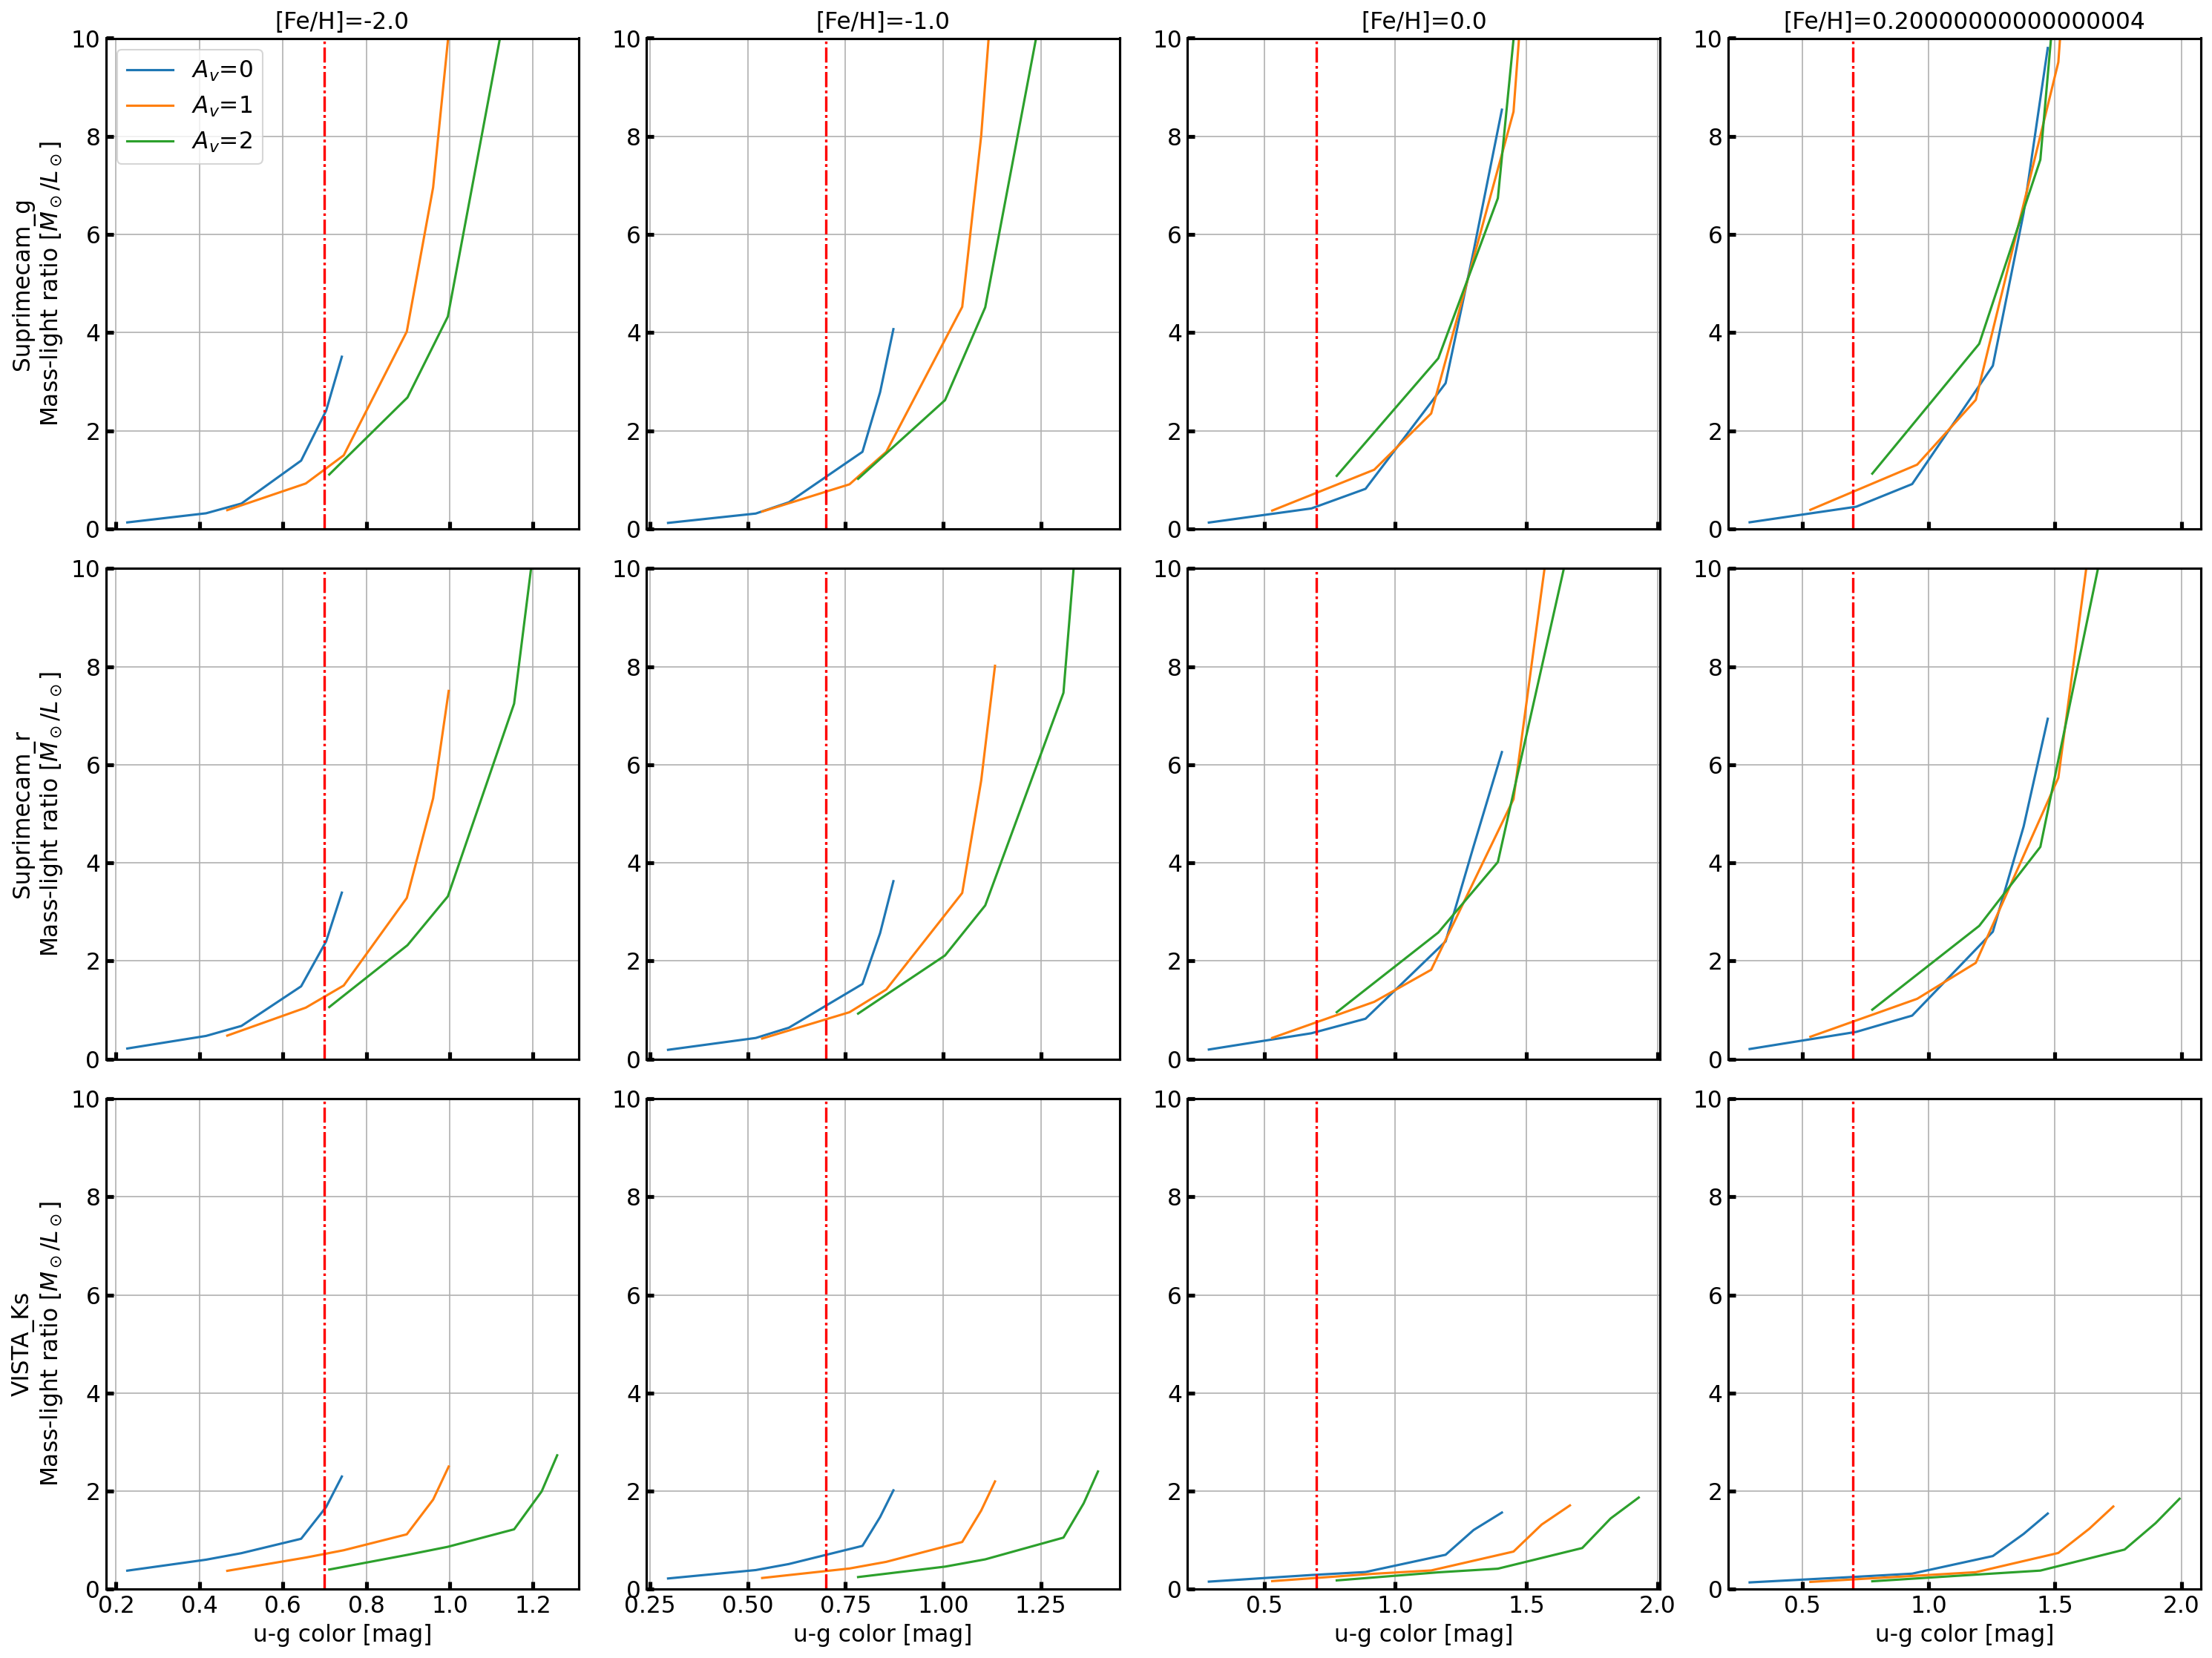

In [10]:
data = np.array(data)
filtername  = ['Suprimecam_g','Suprimecam_r','VISTA_Ks']

fig, axes = plt.subplots(nrows=3,ncols=4,figsize=[20,15])
for i in range(4): # loop: metallicity
    met = mets[i]
    for j in range(3): # loop: g, r, Ks band
        ax = axes[j,i]
        for k in range(3): # loop: extinction
            ydata = data[i,k].data['m2l'][:,j]
            xdata = data[i,k].data['u_g']
            ax.plot(xdata,ydata,label='$A_v$='+str(exts[k]))
            ax.axvline(0.7,ls='-.',color='red')
        ax.grid()
        ax.set_ylim([0,10])
        if( i==0 and j==0 ): ax.legend(loc='upper left')
        if( j!=2 ): ax.set_xticklabels([])
        if( j==0 ): ax.set_title(f'[Fe/H]={np.log10(met)}')
        if( j==2 ): ax.set_xlabel('u-g color [mag]')
        if( i==0 ): ax.set_ylabel(filtername[j]+'\nMass-light ratio [$M_\odot/L_\odot$]')
plt.tight_layout()

### F. If you were using spectroscopy rather than photometry, which spectral features might be useful for inferring the age of a galaxies stellar population? What about its metallicity? Explain why these features are useful given what you know about stellar spectroscopy and stellar evolution (no more than a couple of sentences).

If using spectroscopy data, I'll look for the '4000-angstrom break', which is resulting from metal absorption in old stellar population. Comparing with photometry, that means older stellar population will have a larger u-g color. However, a young galaxy with high metallicity may have a same color as an old, metal-poor galaxy. To break the age-meatllicity degenercy, we can use the depth of Mg (5170 angstrom) and Fe (5370 amgstrom) absroption line to indicate its metallicity.